In [1]:
# 預測影評正負評價 對比(MLP,RNN,LSTM)
# 載入下載 lib
import urllib.request
import os 
import tarfile

In [2]:
url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
filepath= "C:/Users/tom83615/Downloads/aclImdb_v1.tar.gz"
if not os.path.isfile(filepath):
    result = urllib.request.urlretrieve(url, filepath)
    print("Download: ", result)

In [3]:
folderpath = "C:/Users/tom83615/Downloads/"
if not os.path.exists(folderpath + "aclImdb"):
    tfile = tarfile.open(filepath, "r:gz")
    result = tfile.extractall(folderpath)

In [4]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
import numpy as np
import re

In [5]:
# 移除 html tag
def rm_tag(text):
    re_tag = re.compile(r"<[^>]+>")
    return re_tag.sub('', text)

def read_files(filetype):
    path = folderpath + "aclImdb/"
    file_list = []

    postive_path = path + filetype + "/pos/"
    for f in os.listdir(postive_path):
        file_list += [postive_path + f]
    
    negative_path = path + filetype + "/neg/"
    for f in os.listdir(negative_path):
        file_list += [negative_path + f]

    print("read", filepath, "files:", len(file_list))

    all_labels = ([1] * 12500 + [0] * 12500) #正負面評價都有 12500 個

    all_texts = []
    for f in file_list:
        with open(f, encoding= 'utf8') as file_input:
            all_texts += [rm_tag(" ".join(file_input.readlines()))]
    
    return all_labels, all_texts

In [6]:
# 訓練 25000 筆, 正面12500 反面12500
# 驗證 25000 筆, 正面12500 反面12500
y_train, train_text_raw = read_files("train")
y_test, test_text_raw = read_files("test")

read C:/Users/tom83615/Downloads/aclImdb_v1.tar.gz files: 25000
read C:/Users/tom83615/Downloads/aclImdb_v1.tar.gz files: 25000


In [7]:
# 查看第0筆 正面評價
print(train_text_raw[0])
print(y_train[0])

Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!
1


In [8]:
# 查看第12500+1筆 負面評價
print(train_text_raw[12500])
print(y_train[12500])

Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.
0


In [9]:
# 建立 token
token = Tokenizer(num_words=2000)
token.fit_on_texts(train_text_raw)
print(token.document_count)

25000


In [10]:
# 將影評文字轉為數字 list
x_train_seq = token.texts_to_sequences(train_text_raw)
x_test_seq  = token.texts_to_sequences(test_text_raw)

In [11]:
# 將每一組數字 list 都補到 100
x_train = sequence.pad_sequences(x_train_seq, 100)
x_test  = sequence.pad_sequences(x_test_seq,  100)
x_train

array([[  29,    1,  168, ...,   11,    8,  214],
       [ 544,   38,  511, ...,    5,  335,  404],
       [   7, 1638,   22, ...,    6,  175,  395],
       ...,
       [   8,    6,   48, ...,   16,   95,   75],
       [1103,  716,   34, ...,  259, 1194,  792],
       [ 682,   48,  343, ...,   10,    6, 1349]])

In [12]:
# 改變標籤結構 (list => np.array)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [13]:
import otherLib as olib
olib.solve_cudnn_error() # 處理 GPU memory 分配

1 Physical GPUs, 1 Logical GPUs


In [14]:
# 利用 MLP 完成預測模型
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.embeddings import Embedding

In [15]:
# Embedding 層
#   output_dim  輸出為度 32 唯(可動)
#   input_dim   輸入大小 2000 (看之前 Token 建多少個)
#   input_length輸入長度 100 字(看之前補到幾位)
# Dropout 0.2
# Flatten 32*100 個
# 隱藏層
#   units       層數 256
#   activation  啟動函數 線性
# Dropout 0.35
# 輸出層
#   units       數量 1
#   activation  啟動函數 S型函數
model = Sequential()
model.add(
    Embedding(
        output_dim= 32,
        input_dim= 2000,
        input_length= 100
))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(
    units= 256,
    activation= 'relu'
))
model.add(Dropout(0.35))
model.add(Dense(
    units= 1,
    activation= 'sigmoid'
))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 32)           64000     
_________________________________________________________________
dropout (Dropout)            (None, 100, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               819456    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 883,713
Trainable params: 883,713
Non-trainable params: 0
__________________________________________________

In [16]:
# 定義訓練方法
# loss      損失函數 二元交叉熵
# optimizer 最佳化方法 adam
# metrics   最佳化依據 準確率
model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [17]:
# 開始訓練
# x,y               輸入值
# validation_split  拆分 0.2 資料作驗證； 0.8做訓練
# epochs            訓練 10 次
# batch_size        每批次 100 筆資料
train_history = model.fit(
    x = x_train,
    y = y_train,
    validation_split = 0.2,
    epochs = 10,
    batch_size = 100
)

Epoch 1/10
200/200 [==============================] - 1s 4ms/step - accuracy: 0.7574 - loss: 0.4778 - val_loss: 0.3577 - val_accuracy: 0.8510
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - accuracy: 0.8878 - loss: 0.2720 - val_loss: 0.4407 - val_accuracy: 0.8060
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - accuracy: 0.9381 - loss: 0.1693 - val_loss: 0.6381 - val_accuracy: 0.7620
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - accuracy: 0.9704 - loss: 0.0852 - val_loss: 0.9693 - val_accuracy: 0.7262
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - accuracy: 0.9837 - loss: 0.0477 - val_loss: 0.9190 - val_accuracy: 0.7758
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - accuracy: 0.9859 - loss: 0.0406 - val_loss: 1.1494 - val_accuracy: 0.7414
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - accuracy: 0.9892 - loss: 0.0307 - val_loss: 1.1847 - val_accuracy: 0.7602
Epoch 

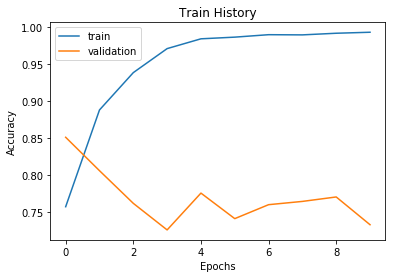

In [18]:
# 畫圖 
olib.show_train_history(train_history)

In [19]:
# 預測準確度
scores = model.evaluate(x_test, y_test)
print('accuracy=', scores[1])

782/782 [==============================] - 1s 2ms/step - accuracy: 0.8042 - loss: 1.0343
accuracy= 0.8041599988937378


Epoch 1/10
200/200 [==============================] - 1s 7ms/step - accuracy: 0.7681 - loss: 0.4598 - val_loss: 0.5288 - val_accuracy: 0.7552
Epoch 2/10
200/200 [==============================] - 1s 6ms/step - accuracy: 0.9345 - loss: 0.1758 - val_loss: 0.4493 - val_accuracy: 0.8168
Epoch 3/10
200/200 [==============================] - 1s 6ms/step - accuracy: 0.9825 - loss: 0.0593 - val_loss: 0.4968 - val_accuracy: 0.8360
Epoch 4/10
200/200 [==============================] - 1s 6ms/step - accuracy: 0.9944 - loss: 0.0209 - val_loss: 0.7489 - val_accuracy: 0.8032
Epoch 5/10
200/200 [==============================] - 1s 6ms/step - accuracy: 0.9983 - loss: 0.0087 - val_loss: 0.8757 - val_accuracy: 0.8018
Epoch 6/10
200/200 [==============================] - 1s 6ms/step - accuracy: 0.9991 - loss: 0.0053 - val_loss: 1.0197 - val_accuracy: 0.7904
Epoch 7/10
200/200 [==============================] - 1s 6ms/step - accuracy: 0.9987 - loss: 0.0058 - val_loss: 1.2012 - val_accuracy: 0.7716
Epoch 

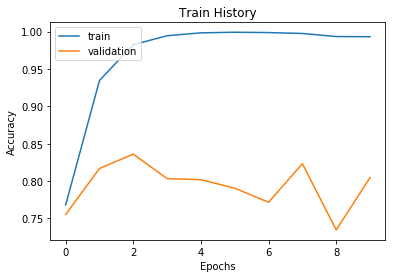

782/782 [==============================] - 2s 2ms/step - accuracy: 0.8481 - loss: 0.7666
accuracy= 0.8480799794197083


In [20]:
# 測試將 token 與最大取樣字常字長提升是否有更高預測機率 (是)
token = Tokenizer(num_words=5000)
token.fit_on_texts(train_text_raw)

x_train_seq = token.texts_to_sequences(train_text_raw)
x_test_seq  = token.texts_to_sequences(test_text_raw)

x_train = sequence.pad_sequences(x_train_seq, 300)
x_test  = sequence.pad_sequences(x_test_seq,  300)

model_MLP = Sequential()
model_MLP.add(
    Embedding(
        output_dim= 32,
        input_dim= 5000,
        input_length= 300
))
model_MLP.add(Dropout(0.2))
model_MLP.add(Flatten())
model_MLP.add(Dense(
    units= 256,
    activation= 'relu'
))
model_MLP.add(Dropout(0.35))
model_MLP.add(Dense(
    units= 1,
    activation= 'sigmoid'
))

model_MLP.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

train_history_large = model_MLP.fit(
    x = x_train,
    y = y_train,
    validation_split = 0.2,
    epochs = 10,
    batch_size = 100
)

olib.show_train_history(train_history_large)

scores = model_MLP.evaluate(x_test, y_test)
print('accuracy=', scores[1])

In [21]:
# 利用 RNN 模型進行訓練
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN 
models_RNN = Sequential()

In [22]:
# Embedding 層
#   output_dim  輸出為度 32 唯(可動)
#   input_dim   輸入大小 5000 (看之前 Token 建多少個)
#   input_length輸入長度 300 字(看之前補到幾位)
# Dropout 0.2
# RNN 
#   units       層數 32
# 隱藏層
#   units       層數 256
#   activation  啟動函數 線性
# Dropout 0.35
# 輸出層
#   units       數量 1
#   activation  啟動函數 S型函數
models_RNN.add(
    Embedding(
        output_dim= 32,
        input_dim= 5000,
        input_length= 300
))
models_RNN.add(Dropout(0.2))
models_RNN.add(SimpleRNN(units=32))
models_RNN.add(Dense(
    units= 256,
    activation= 'relu'
))
models_RNN.add(Dropout(0.35))
models_RNN.add(Dense(
    units= 1,
    activation= 'sigmoid'
))
models_RNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 32)           160000    
_________________________________________________________________
dropout_4 (Dropout)          (None, 300, 32)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 256)               8448      
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 170,785
Trainable params: 170,785
Non-trainable params: 0
________________________________________________

Epoch 1/10
200/200 [==============================] - 17s 86ms/step - accuracy: 0.7329 - loss: 0.5235 - val_loss: 0.5533 - val_accuracy: 0.7434
Epoch 2/10
200/200 [==============================] - 17s 84ms/step - accuracy: 0.8739 - loss: 0.3129 - val_loss: 0.6525 - val_accuracy: 0.7206
Epoch 3/10
200/200 [==============================] - 17s 87ms/step - accuracy: 0.9064 - loss: 0.2378 - val_loss: 0.5047 - val_accuracy: 0.7598
Epoch 4/10
200/200 [==============================] - 17s 86ms/step - accuracy: 0.9362 - loss: 0.1687 - val_loss: 1.0343 - val_accuracy: 0.7022
Epoch 5/10
200/200 [==============================] - 17s 86ms/step - accuracy: 0.9606 - loss: 0.1094 - val_loss: 0.5886 - val_accuracy: 0.8000
Epoch 6/10
200/200 [==============================] - 17s 86ms/step - accuracy: 0.9725 - loss: 0.0740 - val_loss: 0.7621 - val_accuracy: 0.8000
Epoch 7/10
200/200 [==============================] - 18s 91ms/step - accuracy: 0.9829 - loss: 0.0487 - val_loss: 0.8823 - val_accuracy:

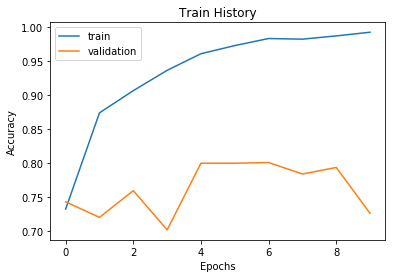

782/782 [==============================] - 14s 18ms/step - accuracy: 0.8162 - loss: 0.9581
accuracy= 0.8161600232124329


In [23]:
# 訓練並產出結果
models_RNN.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

train_history_RNN = models_RNN.fit(
    x = x_train,
    y = y_train,
    validation_split = 0.2,
    epochs = 10,
    batch_size = 100
)

olib.show_train_history(train_history_RNN)

scores = models_RNN.evaluate(x_test, y_test)
print('accuracy=', scores[1])

In [24]:
# 利用 LSTM 模型進行訓練
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM 
models_LSTM = Sequential()

In [25]:
# Embedding 層
#   output_dim  輸出為度 32 唯(可動)
#   input_dim   輸入大小 5000 (看之前 Token 建多少個)
#   input_length輸入長度 300 字(看之前補到幾位)
# Dropout 0.2
# LSTM 
#   units       層數 32
# 隱藏層
#   units       層數 256
#   activation  啟動函數 線性
# Dropout 0.35
# 輸出層
#   units       數量 1
#   activation  啟動函數 S型函數
models_LSTM.add(
    Embedding(
        output_dim= 32,
        input_dim= 5000,
        input_length= 300
))
models_LSTM.add(Dropout(0.2))
models_LSTM.add(SimpleRNN(units=16))
models_LSTM.add(Dense(
    units= 256,
    activation= 'relu'
))
models_LSTM.add(Dropout(0.35))
models_LSTM.add(Dense(
    units= 1,
    activation= 'sigmoid'
))
models_LSTM.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 32)           160000    
_________________________________________________________________
dropout_6 (Dropout)          (None, 300, 32)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 16)                784       
_________________________________________________________________
dense_6 (Dense)              (None, 256)               4352      
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 165,393
Trainable params: 165,393
Non-trainable params: 0
________________________________________________

Epoch 1/10
200/200 [==============================] - 21s 103ms/step - accuracy: 0.7265 - loss: 0.5345 - val_loss: 0.3510 - val_accuracy: 0.8934
Epoch 2/10
200/200 [==============================] - 17s 86ms/step - accuracy: 0.8597 - loss: 0.3501 - val_loss: 0.8171 - val_accuracy: 0.6368
Epoch 3/10
200/200 [==============================] - 17s 86ms/step - accuracy: 0.8897 - loss: 0.2815 - val_loss: 0.5526 - val_accuracy: 0.7802
Epoch 4/10
200/200 [==============================] - 17s 85ms/step - accuracy: 0.9151 - loss: 0.2263 - val_loss: 0.3755 - val_accuracy: 0.8614
Epoch 5/10
200/200 [==============================] - 17s 85ms/step - accuracy: 0.9357 - loss: 0.1752 - val_loss: 0.7202 - val_accuracy: 0.7614
Epoch 6/10
200/200 [==============================] - 17s 85ms/step - accuracy: 0.9580 - loss: 0.1177 - val_loss: 0.3470 - val_accuracy: 0.8856
Epoch 7/10
200/200 [==============================] - 17s 86ms/step - accuracy: 0.9658 - loss: 0.0916 - val_loss: 0.6705 - val_accuracy

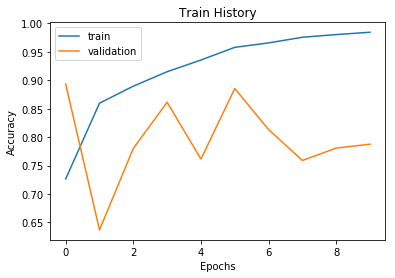

782/782 [==============================] - 12s 15ms/step - accuracy: 0.8252 - loss: 0.7260
accuracy= 0.825160026550293


In [26]:
# 訓練並產出結果
models_LSTM.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

train_history_LSTM = models_LSTM.fit(
    x = x_train,
    y = y_train,
    validation_split = 0.2,
    epochs = 10,
    batch_size = 100
)

olib.show_train_history(train_history_LSTM)

scores = models_LSTM.evaluate(x_test, y_test)
print('accuracy=', scores[1])